In [1]:
import pandas as pd
import numpy as np
from astropy.time import Time
from astropy import units as u
import sncosmo
import matplotlib.pylab as plt

from mcmc_tools_tess import *
from useful_functions import lcImport

In [2]:
ab = sncosmo.get_magsystem('ab')
tess_response = pd.read_csv('./tess_response_curve.csv',header=0,names=['wl_nm','trans'])
tess_response['wl_ang'] = (np.array(tess_response['wl_nm']) * u.nm).to_value('angstrom')

atlaso_response = pd.read_csv('./atlas_o.csv',header=0,names=['wl_ang','trans'])

sn2020bpi_ztf = pd.read_csv('./sn2020bpi_ztf.csv',header=0)
sn2020bpi_ztf['BTJD'] = Time(sn2020bpi_ztf['mjd'],format='mjd').jd - 2457000.0
sn2020bpi_ztf['magap_rolling'] = sn2020bpi_ztf['magap'].rolling(12).median()
sn2020bpi_ztf['flux'] = [ab.band_mag_to_flux(sn2020bpi_ztf['magap'][i], 'ztfr') for i in range(len(sn2020bpi_ztf['magap']))]
sn2020bpi_ztf['flux_rolling'] = sn2020bpi_ztf['flux'].rolling(12).median()

In [3]:
sn2020bpi_s21_dir = './Fausnaugh/sector21/cam3_ccd2/lc/lc_2020bpi_cleaned'
sn2020bpi_s21 = lcImport(sn2020bpi_s21_dir)
sn2020bpi_s21['cts_median'] = sn2020bpi_s21['cts'].rolling(24).median()
sn2020bpi_s21['e_cts_median'] = sn2020bpi_s21['e_cts'].rolling(24).median()
sn2020bpi_s21['mjd'] = Time(sn2020bpi_s21['BTJD']+2457000.0, format='jd').mjd

sn2020bpi_s22_dir = './Fausnaugh/sector22/cam3_ccd1/lc/lc_2020bpi_cleaned'
sn2020bpi_s22 = lcImport(sn2020bpi_s22_dir)
sn2020bpi_s22['cts_median'] = sn2020bpi_s22['cts'].rolling(24).median()
sn2020bpi_s22['e_cts_median'] = sn2020bpi_s22['e_cts'].rolling(24).median()
sn2020bpi_s22['mjd'] = Time(sn2020bpi_s22['BTJD']+2457000.0, format='jd').mjd

sn2020bpi_s22_fix = (1912,1914.5)
sn2020bpi_s22_fixed = sn2020bpi_s22.query('BTJD > 1900')
sn2020bpi_s22_fixed = sn2020bpi_s22_fixed[(sn2020bpi_s22_fixed['BTJD'] < sn2020bpi_s22_fix[0]) | (sn2020bpi_s22_fixed['BTJD'] > sn2020bpi_s22_fix[1])]

sn2020bpi_s21s22 = pd.concat([sn2020bpi_s21,sn2020bpi_s22_fixed])
sn2020bpi_s21s22['cts_bkg_model_sub'] = sn2020bpi_s21s22['cts'] - sn2020bpi_s21s22['bkg_model']

In [4]:
tess_start_mjd = sn2020bpi_s21s22['mjd'].min()
tess_end_mjd = sn2020bpi_s21s22['mjd'].max()
sn2020bpi_ztf_r = sn2020bpi_ztf.query('fid == 2 & mjd > @tess_start_mjd & mjd < @tess_end_mjd').reset_index()

In [5]:
sn2020bpi_ztf_r.keys()

Index(['index', 'candid_str', 'oid', 'candid', 'mjd', 'fid', 'diffmaglim',
       'magpsf', 'magap', 'sigmapsf', 'sigmagap', 'ra', 'dec', 'sigmara',
       'sigmadec', 'isdiffpos', 'distpsnr1', 'sgscore1', 'field', 'rcid',
       'magnr', 'sigmagnr', 'rb', 'magpsf_corr', 'magap_corr', 'sigmapsf_corr',
       'sigmagap_corr', 'has_stamps', 'parent_candid', 'BTJD', 'magap_rolling',
       'flux', 'flux_rolling'],
      dtype='object')

In [6]:
tess_2020bpi = pd.read_csv('JhaData/TESS_SN2020bpi.csv')
tess_2020bpi['mjd'] = tess_2020bpi['mjd'] - np.min(tess_2020bpi['mjd'])
tess_2020bpi.head()

,BTJD,mjd,cts,e_cts,bkg_model,raw_flux,e_flux,bkg_model_flux,corr_flux
0,1870.44408,0.00000,-5339.0302,1368.8706,1502.1435,-0.030663,0.007862,0.008627,0.002060
1,1870.44408,0.00000,-5334.2775,1367.3354,1502.1435,-0.030636,0.007853,0.008627,0.002085
2,1870.46491,0.02083,-6841.1413,1375.3282,1502.1435,-0.039290,0.007899,0.008627,-0.006033
3,1870.46491,0.02083,-6820.1378,1373.8129,1502.1435,-0.039169,0.007890,0.008627,-0.005920
4,1870.48574,0.04166,-2219.7583,1400.7610,1501.2344,-0.012748,0.008045,0.008622,0.018870


In [7]:
ztf_2020bpi = pd.read_csv('JhaData/ztf_SN2020bpi.csv')
ztf_2020bpi['flux_err'] = 0.008*np.ones(len(ztf_2020bpi))
ztf_2020bpi['mjd'] = ztf_2020bpi['mjd'] - np.min(ztf_2020bpi['mjd'])
ztf_2020bpi.head()

,BTJD,mjd,magap,sig_magap,flux,flux_err
0,1879.870567,0.000000,19.729799,0.2218,0.014224,0.008
1,1881.011065,1.140498,19.959801,0.2436,0.011509,0.008
2,1881.031343,1.160775,19.473101,0.1538,0.018018,0.008
3,1881.843854,1.973287,19.660400,0.2291,0.015163,0.008
4,1882.032546,2.161979,19.363001,0.1425,0.019941,0.008


In [8]:
tess_2020bpi.rename(columns={'raw_flux':'flux','e_flux':'flux_err'},inplace=True)
tess_2020bpi.head()

,BTJD,mjd,cts,e_cts,bkg_model,flux,flux_err,bkg_model_flux,corr_flux
0,1870.44408,0.00000,-5339.0302,1368.8706,1502.1435,-0.030663,0.007862,0.008627,0.002060
1,1870.44408,0.00000,-5334.2775,1367.3354,1502.1435,-0.030636,0.007853,0.008627,0.002085
2,1870.46491,0.02083,-6841.1413,1375.3282,1502.1435,-0.039290,0.007899,0.008627,-0.006033
3,1870.46491,0.02083,-6820.1378,1373.8129,1502.1435,-0.039169,0.007890,0.008627,-0.005920
4,1870.48574,0.04166,-2219.7583,1400.7610,1501.2344,-0.012748,0.008045,0.008622,0.018870


In [21]:
tess_cut = tess_2020bpi.copy(deep=True)
tess_cut = tess_cut[(tess_cut.mjd > 1) & (tess_cut.mjd < 13.5)]
tess_cut['flux'] = tess_cut['flux'] - np.min(tess_cut['flux'])
tess_cut['flux'] = tess_cut['flux'] - np.mean(tess_cut['flux'][tess_cut.mjd < 6])

ztf_cut = ztf_2020bpi.copy(deep=True)
ztf_cut = ztf_cut[(ztf_cut.mjd > 0) & (ztf_cut.mjd < 10)]
ztf_cut['flux'] = ztf_cut['flux'] - np.min(ztf_cut['flux'])
ztf_cut['flux'] = ztf_cut['flux'] - np.mean(ztf_cut['flux'][ztf_cut.mjd < 3])

In [41]:
err_model = lambda slope, mjd: mjd*slope

tess_cut_err = tess_cut.copy(deep=True)
tess_cut_err['flux_err'] = np.sqrt(tess_cut_err['flux_err']**2.0 + err_model(5e-5,tess_cut['mjd']))

ztf_cut_err = ztf_cut.copy(deep=True)
ztf_cut_err['flux_err'] = np.sqrt(ztf_cut_err['flux_err']**2.0 + err_model(5e-5,ztf_cut['mjd']))

In [29]:
def model(data, t0, a, power, offset):
    ret = np.zeros(len(data))
    ret[data-t0 > 0] = a * (data[data-t0 > 0] - t0)**power
    ret+=offset
    return ret

def logl(data, model, theta):
    t0,a,sigma,power,offset = theta
    var = (data['flux_err']**2 + sigma**2)
    loglike = -0.5 * (np.sum(np.log(2*np.pi*var) + ((data['flux'] - model(data['flux'],t0,a,power,offset))**2 / var) ))
    return loglike

def fullEmceePlot(data, guess, scale):
    samples = doMCMC(data, guess, scale)
    percentiles = np.percentile(samples, [16,84], axis=0)
    t0 = np.median(samples[:,0])
    t0_p = percentiles[:,0]
    a = np.median(samples[:,1])
    a_p = percentiles[:,1]
    power = np.median(samples[:,3])
    power_p = percentiles[:,3]
    sigma = np.median(samples[:,2])
    sigma_p = percentiles[:,2]
    if len(guess) == 5:
        off = np.median(samples[:,4])
        off_p = percentiles[:,4]
    else:
        off = 0.0
        off_p = np.zeros(len(percentiles[:,0]))
     
    mod = model(np.linspace(np.min(data['mjd']),np.max(data['mjd']),100), t0, a, power, off)
    
    plt.figure()
    plt.errorbar(data['mjd'],data['flux'],yerr=data['flux_err'],
             color='black',linestyle='',alpha=0.5)
    plt.plot(np.linspace(np.min(data['mjd']),np.max(data['mjd']),100),mod,'b')

(0.0, 0.075)

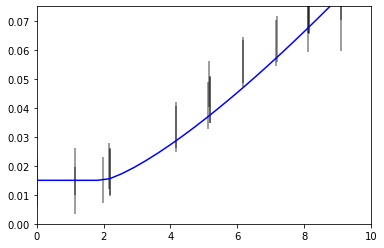

In [37]:
mod = model(np.linspace(np.min(ztf_2020bpi['mjd']),np.max(ztf_2020bpi['mjd']),100), 2, .005, 1.3, 0.015)
    
plt.figure()
plt.errorbar(ztf_2020bpi['mjd'],ztf_2020bpi['flux'],yerr=ztf_2020bpi['flux_err'],
         color='black',linestyle='',alpha=0.5)
plt.plot(np.linspace(np.min(ztf_2020bpi['mjd']),np.max(ztf_2020bpi['mjd']),100),mod,'b')
plt.xlim([0,10])
plt.ylim(0,0.075)

(-0.1, 0.1)

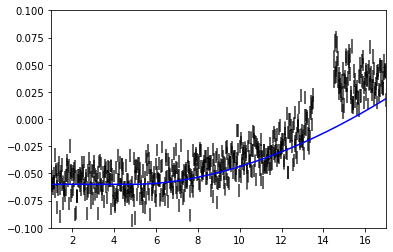

In [13]:
mod = model(np.linspace(np.min(tess_2020bpi['mjd']),np.max(tess_2020bpi['mjd']),100), 5, .0009, 1.8, -0.06)
    
plt.figure()
plt.errorbar(tess_2020bpi['mjd'],tess_2020bpi['flux'],yerr=tess_2020bpi['flux_err'],
         color='black',linestyle='',alpha=0.5)
plt.plot(np.linspace(np.min(tess_2020bpi['mjd']),np.max(tess_2020bpi['mjd']),100),mod,'b')
plt.xlim([1,17])
plt.ylim(-0.1,0.1)

In [33]:
guess_ztf = [2, 0.005, 0.0, 1.3]
guess_tess = [5, 0.0009, 0.0, 1.8]
scale = [0.05, 1e-6, 0.001, 0.005]

guess_ztf_off = [2, 0.005, 0.0, 1.3, 0.0]
guess_tess_off = [5, 0.0009, 0.0, 1.8, 0.0]
scale_off = [0.005, 1e-5, 0.001, 0.005, 0.001]

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [08:52<00:00,  5.64it/s]


done


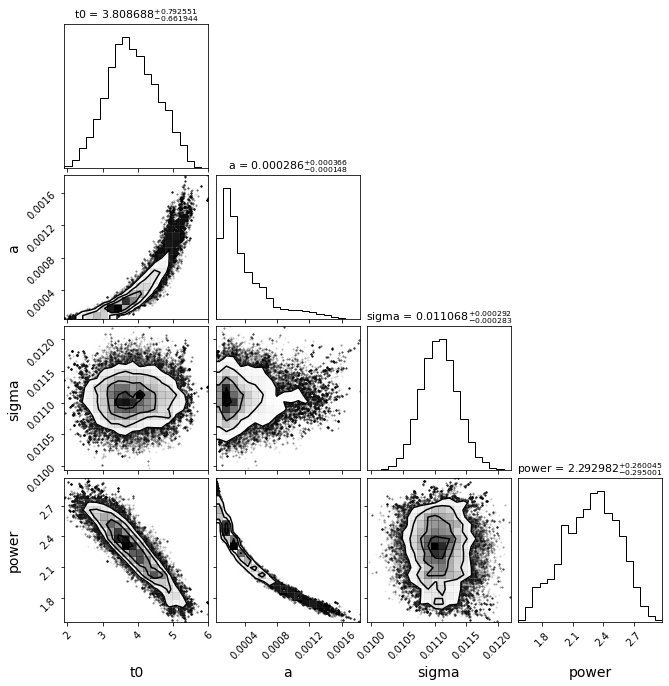

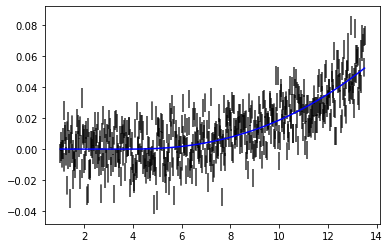

In [30]:
fullEmceePlot(tess_cut,guess_tess,scale)

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [09:15<00:00,  5.40it/s]


done


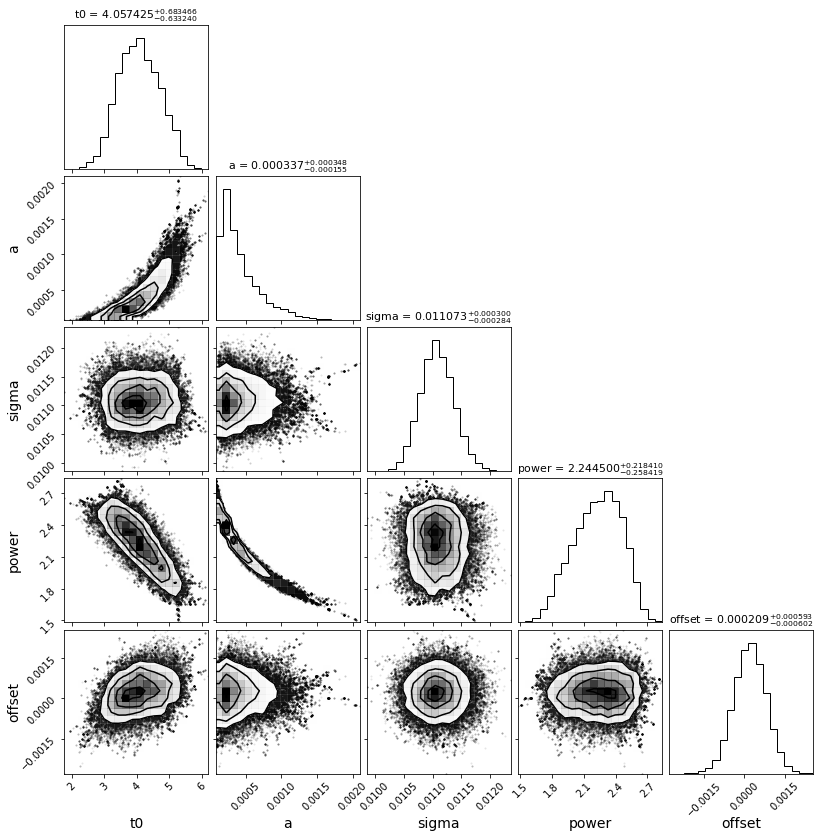

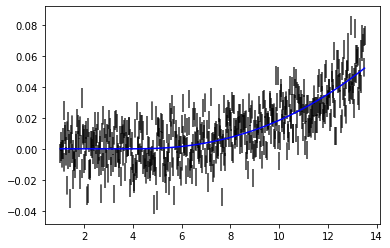

In [34]:
fullEmceePlot(tess_cut,guess_tess_off,scale_off)

  0%|          | 2/3000 [00:00<04:54, 10.17it/s]

sampling...


100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


done


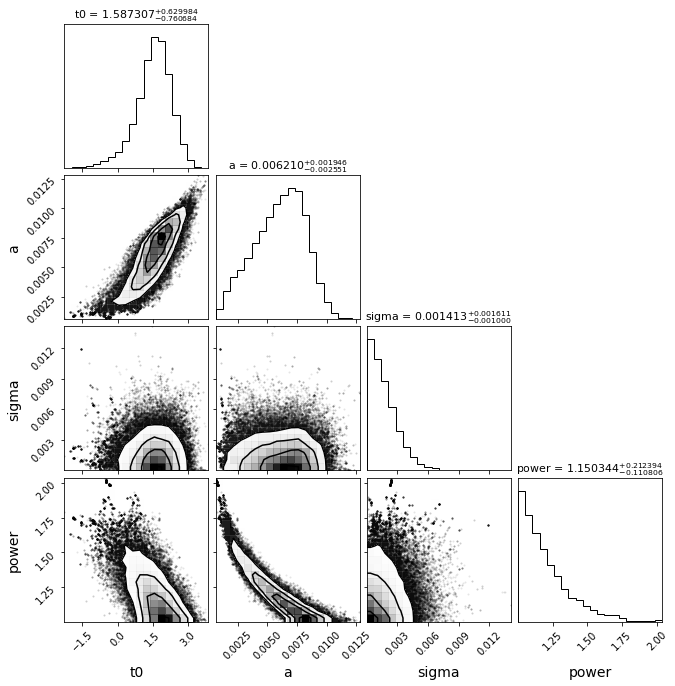

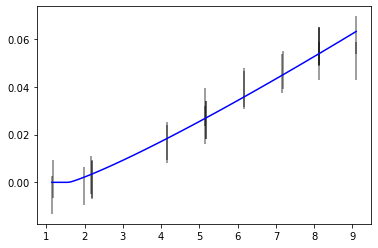

In [31]:
fullEmceePlot(ztf_cut,guess_ztf,scale)

  0%|          | 4/3000 [00:00<04:35, 10.86it/s]

sampling...


100%|██████████| 3000/3000 [06:41<00:00,  7.48it/s]


done


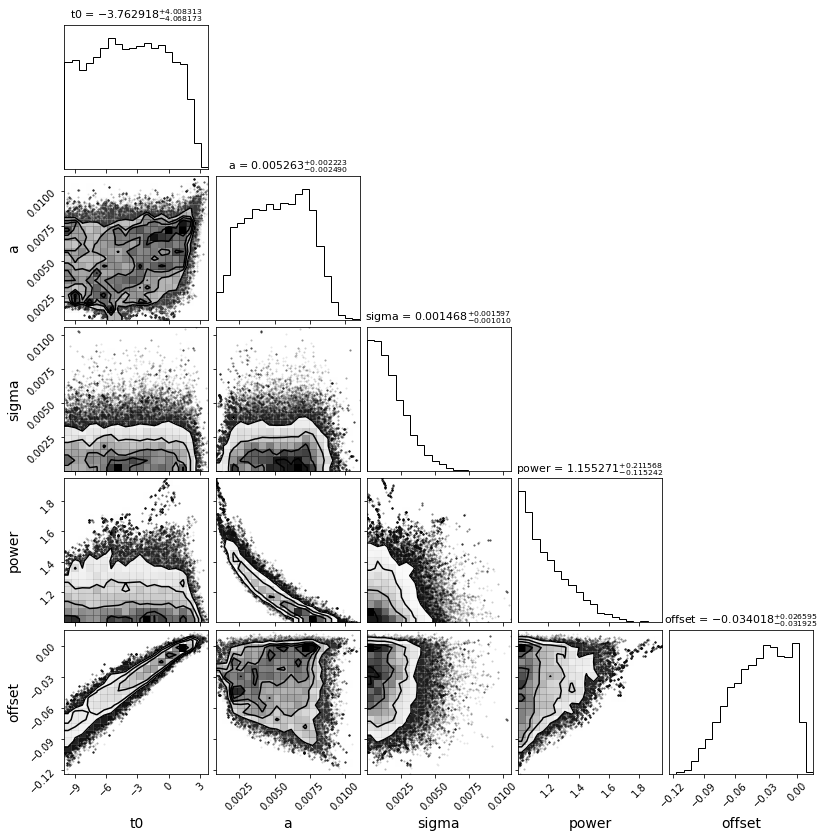

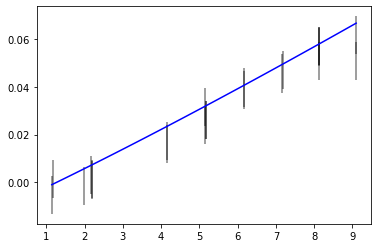

In [35]:
fullEmceePlot(ztf_cut,guess_ztf_off,scale_off)

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [08:08<00:00,  6.15it/s]


done


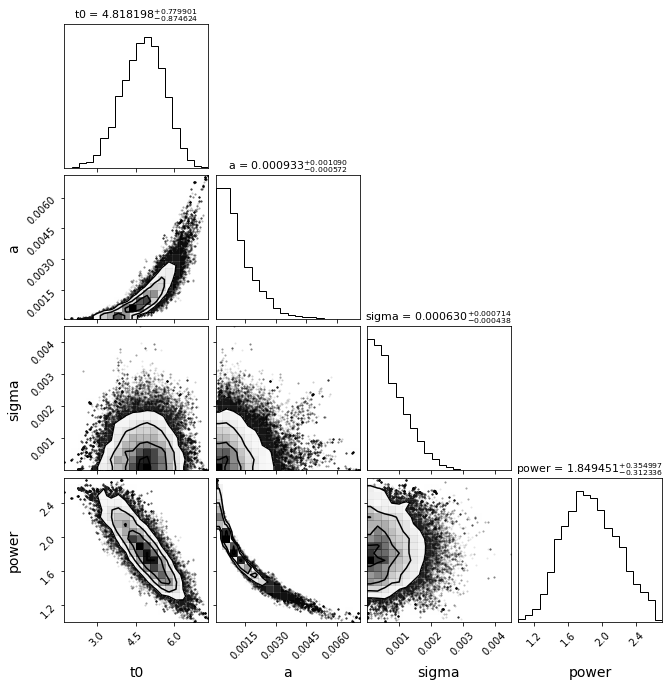

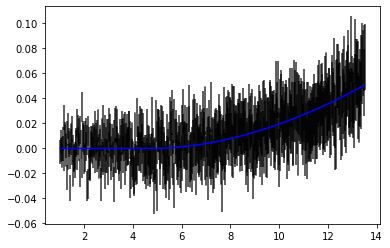

In [42]:
fullEmceePlot(tess_cut_err,guess_tess,scale)

  0%|          | 3/3000 [00:00<04:30, 11.06it/s]

sampling...


100%|██████████| 3000/3000 [06:58<00:00,  7.17it/s]


done


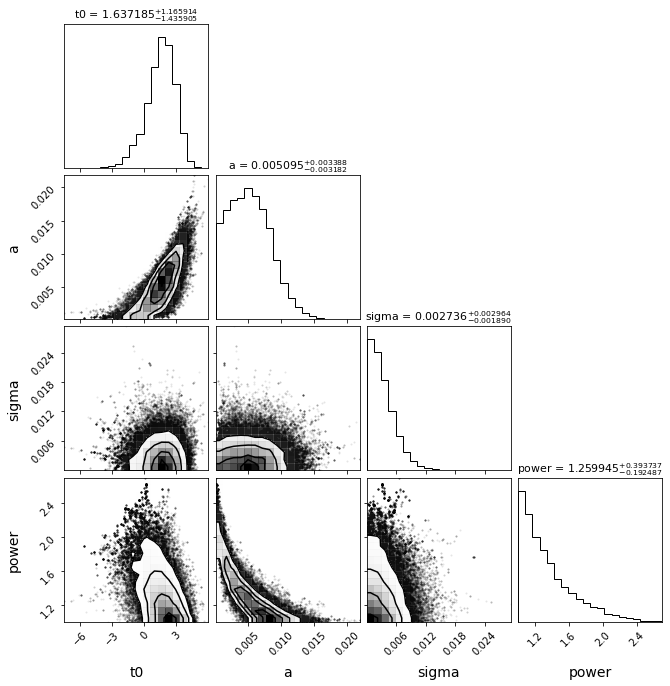

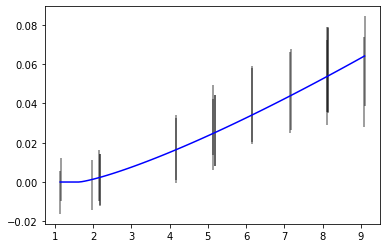

In [43]:
fullEmceePlot(ztf_cut_err,guess_ztf,scale)